In [1]:
import tensorflow as tf
import os
import shutil
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import random
from fractions import Fraction
import math
import mediapipe as mp

## Data

Resoultion is 1920 by 1080 (W/H)

## Preprocessing

In [2]:
def get_files(path):
    f = []
    with os.scandir(path) as entries:
        for entry in entries:
            if entry.is_file():
                f.append(entry.name)
    return f

def get_class(path):
    return int(path.split('_')[0])

def get_files_per_class(files):
    files_for_class = {}
    
    for fname in files:
        class_name = get_class(fname)
        if files_for_class.get(class_name, 0) != 0:
            files_for_class[class_name].append(fname)
        else:
            files_for_class[class_name] = [fname]
    
    return files_for_class

In [3]:
all_files = get_files('./dataset/lsa64/all/')
files_for_class = get_files_per_class(all_files)
classes = list(files_for_class.keys())

In [29]:
# Do not Run
# Find the average and median number of frames used for describing each word (for now n = 10) and check the frame dimensions

class_frame_info = {}

for class_ in files_for_class:
    result = []
    for file in files_for_class[class_]:
        cap = cv2.VideoCapture(f'./dataset/lsa64/all/{file}')
        result.append(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()
    result = np.array(result)
    class_frame_info[class_] = {}
    class_frame_info[class_]['mean'] = np.mean(result)
    class_frame_info[class_]['median'] = np.median(result)

In [30]:
class_frame_info

{1: {'mean': 118.0, 'median': 118.0},
 2: {'mean': 123.4, 'median': 118.0},
 3: {'mean': 119.8, 'median': 118.0},
 4: {'mean': 101.8, 'median': 88.0},
 5: {'mean': 133.0, 'median': 133.0},
 6: {'mean': 154.6, 'median': 148.0},
 7: {'mean': 108.4, 'median': 118.0},
 8: {'mean': 101.8, 'median': 88.0},
 9: {'mean': 124.6, 'median': 118.0},
 10: {'mean': 98.8, 'median': 88.0},
 11: {'mean': 103.6, 'median': 103.0},
 12: {'mean': 127.6, 'median': 118.0},
 13: {'mean': 110.8, 'median': 118.0},
 14: {'mean': 94.0, 'median': 88.0},
 15: {'mean': 92.8, 'median': 88.0},
 16: {'mean': 115.6, 'median': 118.0},
 17: {'mean': 98.2, 'median': 88.0},
 18: {'mean': 121.0, 'median': 118.0},
 19: {'mean': 91.6, 'median': 88.0},
 20: {'mean': 97.6, 'median': 88.0},
 21: {'mean': 128.2, 'median': 118.0},
 22: {'mean': 116.2, 'median': 118.0},
 23: {'mean': 121.6, 'median': 118.0},
 24: {'mean': 129.2, 'median': 122.0},
 25: {'mean': 139.4, 'median': 152.0},
 26: {'mean': 129.2, 'median': 122.0},
 27: {'me

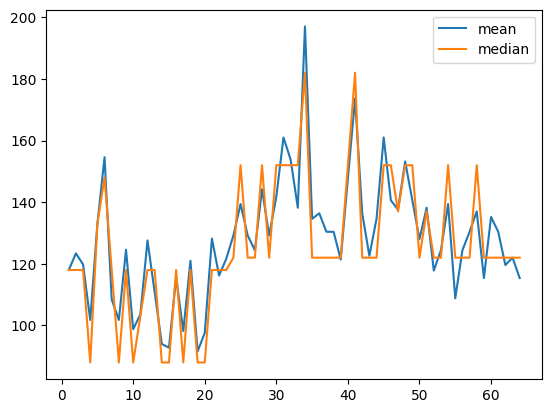

In [31]:
plt.plot(class_frame_info.keys(), [x['mean'] for x in class_frame_info.values()], label='mean')
plt.plot(class_frame_info.keys(), [x['median'] for x in class_frame_info.values()], label='median')
plt.legend()
plt.show()

In [33]:
# Do not Run

with open('./lsa64-info/nframes.json', 'w') as f:
    json_data = json.dumps(class_frame_info)
    f.write(json_data)

In [4]:
with open('./lsa64-info/nframes.json', 'r') as read_content:
    class_frame_info = json.load(read_content)
    class_frame_info = {int(k):v for k, v in class_frame_info.items()}

In [11]:
medians = []

for class_ in classes:
    medians.append(class_frame_info[int(class_)]['median'])

np.median(medians)

122.0

In [12]:
m = np.unique(medians, return_counts=True)
list(zip(*m))

[(88.0, 8),
 (103.0, 1),
 (118.0, 12),
 (122.0, 24),
 (133.0, 1),
 (137.0, 2),
 (148.0, 1),
 (152.0, 13),
 (182.0, 2)]

In [26]:
all_files = get_files('../lsa64/all/')
files_for_class = get_files_per_class(all_files)
classes = list(files_for_class.keys())

max_f = 0

for class_ in files_for_class:
    result = []
    for file in files_for_class[class_]:
        cap = cv2.VideoCapture(f'../lsa64/all/{file}')
        result.append(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()
    max_f = max(max_f, max(result))
    result = np.array(result)

In [27]:
max_f

242.0

Frames = 122, Max n_frames = 242

Frames Dimensions = (512, 288) = (W, H) -> With preserving aspect ratio for (512, 512)

In [22]:
src = cv2.VideoCapture(f'./dataset/lsa64/all/train/1/001_001_001.mp4')
ret, frame = src.read()
# frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
frame = tf.image.convert_image_dtype(frame, tf.float32)
frame = tf.image.resize(frame, (512, 512), preserve_aspect_ratio=True).numpy()
# frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

while True:
    cv2.imshow("display", frame)
    if cv2.waitKey(5000) == ord('q'):
        break
src.release()
cv2.destroyAllWindows()

In [3]:
# Do not run

all_files = get_files('./dataset/lsa64/all/')
files_for_class = get_files_per_class(all_files)

source_path = './dataset/lsa64/all'
classes = list(map(str, files_for_class.keys()))

for class_ in classes:
    files = files_for_class[int(class_)] 
    os.makedirs(source_path + '/train/' + class_)
    os.makedirs(source_path + '/val/' + class_)
    os.makedirs(source_path + '/test/' + class_)
    
    np.random.shuffle(files)
    
    train_files, val_files, test_files = np.split(files, [int(len(files) * (0.8)), int(len(files) * (0.9))])
    
    train_files = [source_path + '/' + name for name in train_files.tolist()]
    val_files = [source_path + '/' + name for name in val_files.tolist()]
    test_files = [source_path + '/' + name for name in test_files.tolist()]
    
    for name in train_files:
        shutil.move(name, source_path + '/train/' + class_)
        
    for name in val_files:
        shutil.move(name, source_path + '/val/' + class_)
        
    for name in test_files:
        shutil.move(name, source_path + '/test/' + class_)

In [3]:
train_files = []

for i in range(1, 64+1):
    train_files.extend(get_files(f'./dataset/lsa64/all/train/{i}'))

In [4]:
def preprocess_image(frame):
    frame = tf.image.convert_image_dtype(frame, tf.float32)
    frame = tf.image.resize(frame, (512, 512), preserve_aspect_ratio=True).numpy()
    return frame
    
def sequential_frames(src, n_frames):
    result = []
    for f in range(n_frames):
        ret, frame = src.read()
        if ret:
            result.append(preprocess_image(frame))
        else:
            result.append(np.zeros_like(result[0]))
    return result

def frames_from_video(path, n_frames):
    src = cv2.VideoCapture(path)
    video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

    if video_length <= n_frames:
        frame_step = 0
        result = sequential_frames(src, n_frames)
        result = np.array(result)[..., [2, 1, 0]]
        src.release()
        return result
    f = 0
    ratio = round(video_length/n_frames, 1)
    frac = Fraction(ratio).limit_denominator(10)

    if ratio == 1.7 or ratio == 1.9:
        frac = Fraction(ratio).limit_denominator(2)

    num, den = frac.numerator, frac.denominator
    result = []
    while f < n_frames:
        for _ in range(min(den, n_frames-f)):
            ret, frame = src.read()
            if ret:
                result.append(preprocess_image(frame))
            else:
                result.append(np.zeros_like(result[0]))
            f += 1
        for _ in range(num-den):
            ret, frame = src.read()

    src.release()
    result = np.array(result)[..., [2, 1, 0]]
    return result

class FrameGenerator:
    def __init__(self, path, n_frames, training = False):
        self.path = path
        self.n_frames = n_frames
        self.training = training

    def get_files_and_class_names(self):
        video_paths = []
        classes = []
        for i in range(1, 64+1):
            files = get_files(f'{self.path}/{i}')
            video_paths.extend(get_files(f'{self.path}/{i}'))
            classes.extend([i]*len(files))
        return video_paths, classes

    def __call__(self):
        video_paths, classes = self.get_files_and_class_names()

        pairs = list(zip(video_paths, classes))

        if self.training:
            random.shuffle(pairs)

        for path, name in pairs:
            video_frames = frames_from_video(f'{self.path}/{name}/{path}', self.n_frames) 
            yield video_frames, name

In [5]:
fg = FrameGenerator('./dataset/lsa64/all/train', 122, training=True)

frames, label = next(fg())

print(f"Shape: {frames.shape}")
print(f"Label: {label}")

Shape: (122, 288, 512, 3)
Label: 30


In [6]:
output_signature = (tf.TensorSpec(shape = (None, 288, 512, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))
train_ds = tf.data.Dataset.from_generator(FrameGenerator('./dataset/lsa64/all/train', 122, training=True),
                                          output_signature = output_signature)

In [7]:
for frames, labels in train_ds.take(10):
    print(labels)

tf.Tensor(21, shape=(), dtype=int16)
tf.Tensor(22, shape=(), dtype=int16)
tf.Tensor(18, shape=(), dtype=int16)
tf.Tensor(57, shape=(), dtype=int16)
tf.Tensor(9, shape=(), dtype=int16)
tf.Tensor(16, shape=(), dtype=int16)
tf.Tensor(57, shape=(), dtype=int16)
tf.Tensor(29, shape=(), dtype=int16)
tf.Tensor(20, shape=(), dtype=int16)
tf.Tensor(10, shape=(), dtype=int16)


In [8]:
val_ds = tf.data.Dataset.from_generator(FrameGenerator('./dataset/lsa64/all/val/', 122),
                                        output_signature = output_signature)

### Keras Sequence

In [3]:
def get_files_and_class_names(path):
    video_paths = []
    classes = []
    for i in range(1, 64+1):
        files = get_files(f'{path}/{i}')
        video_paths.extend(get_files(f'{path}/{i}'))
        classes.extend([i]*len(files))
    return np.array(video_paths), np.array(classes)

In [5]:
src = cv2.VideoCapture(f'./dataset/lsa64/all/train/1/001_001_001.mp4')
ret, frame = src.read()
# frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
frame = tf.image.convert_image_dtype(frame, tf.float32)
frame = tf.image.resize_with_pad(frame, 224, 224).numpy()
# frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
print(len(frame[0]), len(frame))

while True:
    cv2.imshow("display", frame)
    if cv2.waitKey(5000) == ord('q'):
        break
src.release()
cv2.destroyAllWindows()

224 224


In [4]:
def preprocess_image(frame):
    frame = tf.image.convert_image_dtype(frame, tf.float32)
    frame = tf.image.resize_with_pad(frame, 224, 224).numpy()
    # frame = tf.image.resize(frame, (512, 512), preserve_aspect_ratio=True).numpy()
    return frame

def sequential_frames(src, n_frames):
    result = []
    for f in range(n_frames):
        ret, frame = src.read()
        if ret:
            result.append(preprocess_image(frame))
        else:
            result.append(np.zeros_like(result[0]))
    return result

def frames_from_video(path, n_frames):
    src = cv2.VideoCapture(path)
    video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

    if video_length <= n_frames:
        frame_step = 0
        result = sequential_frames(src, n_frames)
        result = np.array(result)[..., [2, 1, 0]]
        src.release()
        return result
    f = 0
    ratio = round(video_length/n_frames, 1)
    frac = Fraction(ratio).limit_denominator(10)

    if ratio == 1.7 or ratio == 1.9:
        frac = Fraction(ratio).limit_denominator(2)

    num, den = frac.numerator, frac.denominator
    result = []
    while f < n_frames:
        for _ in range(min(den, n_frames-f)):
            ret, frame = src.read()
            if ret:
                result.append(preprocess_image(frame))
            else:
                result.append(np.zeros_like(result[0]))
            f += 1
        for _ in range(num-den):
            ret, frame = src.read()

    src.release()
    result = np.array(result)[..., [2, 1, 0]]
    return result

In [5]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, root_path, paths, labels, n_frames, batch_size = 1, training = False):
        self.root_path = root_path
        self.paths = paths
        self.labels = labels
        self.n_frames = n_frames
        self.training = training
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.paths))
        if self.training:
            np.random.shuffle(self.indexes)

    def get_video_frames(self, video_paths, classes):
        result_X = []
        result_y = []
        pairs = list(zip(video_paths, classes))

        for path, name in pairs:
            video_frames = frames_from_video(f'{self.root_path}/{name}/{path}', self.n_frames) 
            result_X.append(video_frames)
            result_y.append(name)
        
        return np.array(result_X), np.array(result_y)
            
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        return self.get_video_frames(self.paths[indexes], self.labels[indexes])
    
    def __len__(self):
        return math.floor(len(self.paths) / self.batch_size)
    
    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

In [6]:
def get_video_frames(video_paths, classes):
    result_X = []
    result_y = []
    pairs = list(zip(video_paths, classes))

    for path, name in pairs:
        video_frames = frames_from_video(f'./dataset/lsa64/all/train/{name}/{path}', 122) 
        result_X.append(video_frames)
        result_y.append(name)

    return np.array(result_X), np.array(result_y)

In [9]:
x, y = get_video_frames(['001_001_001.mp4'], [1])

In [49]:
x.shape

(1, 122, 288, 512, 3)

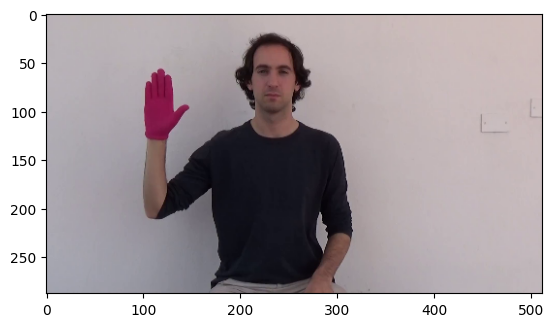

In [50]:
plt.imshow(x[0][0])

In [8]:
train_gen = DataGenerator('./dataset/lsa64/all/train/', *get_files_and_class_names('./dataset/lsa64/all/train/'), 122, training=True)
val_gen = DataGenerator('./dataset/lsa64/all/val/', *get_files_and_class_names('./dataset/lsa64/all/val/'), 122)

In [9]:
steps_per_epoch = len(train_gen)
validation_steps = len(val_gen)

In [10]:
net = tf.keras.applications.EfficientNetB0(include_top = False)
net.trainable = False

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=255),
    tf.keras.layers.TimeDistributed(net),
    tf.keras.layers.Dense(64),
    tf.keras.layers.GlobalAveragePooling3D()
])

model.compile(optimizer = 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [11]:
history = model.fit(train_gen, epochs=1, steps_per_epoch=steps_per_epoch, validation_data=val_gen, validation_steps=validation_steps)

  13/2560 [..............................] - ETA: 4:25:00 - loss: 4.4715 - accuracy: 0.0000e+00

KeyboardInterrupt: 

### Previous Model

In [7]:
# def preprocess_image(frame):
#     frame = tf.image.convert_image_dtype(frame, tf.float32)
#     frame = tf.image.resize_with_pad(frame, 224, 224).numpy()
#     # frame = tf.image.resize(frame, (512, 512), preserve_aspect_ratio=True).numpy()
#     return frame

# def sequential_frames(src, n_frames):
#     result = []
#     for f in range(n_frames):
#         ret, frame = src.read()
#         if ret:
#             result.append(preprocess_image(frame))
#         else:
#             result.append(np.zeros_like(result[0]))
#     return result

# def frames_from_video(path, n_frames):
#     src = cv2.VideoCapture(path)
#     video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

#     if video_length <= n_frames:
#         frame_step = 0
#         result = sequential_frames(src, n_frames)
#         result = np.array(result)[..., [2, 1, 0]]
#         src.release()
#         return result
#     f = 0
#     ratio = round(video_length/n_frames, 1)
#     frac = Fraction(ratio).limit_denominator(10)

#     if ratio == 1.7 or ratio == 1.9:
#         frac = Fraction(ratio).limit_denominator(2)

#     num, den = frac.numerator, frac.denominator
#     result = []
#     while f < n_frames:
#         for _ in range(min(den, n_frames-f)):
#             ret, frame = src.read()
#             if ret:
#                 result.append(preprocess_image(frame))
#             else:
#                 result.append(np.zeros_like(result[0]))
#             f += 1
#         for _ in range(num-den):
#             ret, frame = src.read()

#     src.release()
#     result = np.array(result)[..., [2, 1, 0]]
#     return result

In [36]:
def get_files_and_class_names(path):
    video_paths = []
    classes = []
    for i in range(1, 32+1):
        files = get_files(f'{path}/{i}')
        video_paths.extend(get_files(f'{path}/{i}')[:15])
        classes.extend([i]*len(files)[:15])
    return np.array(video_paths), np.array(classes)

In [37]:
from fractions import Fraction

def save_holistic(holistic, image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = holistic.process(image)
    image.flags.writeable = True

    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

    landmarks = np.concatenate([pose, face, lh, rh])
    return landmarks
    
def sequential_frames(src, holistic, n_frames):
    result = []
    for f in range(n_frames):
        ret, frame = src.read()
        if ret:
            result.append(save_holistic(holistic, frame))
        else:
            result.append(np.zeros((1662, )))
    return result

def frames_from_video(path, n_frames):
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    mp_holistic = mp.solutions.holistic
    
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        src = cv2.VideoCapture(path)
        video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)
        
        if video_length <= n_frames:
            frame_step = 0
            return sequential_frames(src, holistic, n_frames)
        else:
            result = []
            f = 0
            ratio = round(video_length/n_frames, 1)
            frac = Fraction(ratio).limit_denominator(10)
            
            if ratio == 1.7 or ratio == 1.9:
                frac = Fraction(ratio).limit_denominator(2)
            
            num, den = frac.numerator, frac.denominator
            while f < n_frames:
                for _ in range(min(den, n_frames-f)):
                    ret, frame = src.read()
                    if ret:
                        result.append(save_holistic(holistic, frame))
                    else:
                        result.append(np.zeros((1662, )))
                    f += 1
                for _ in range(num-den):
                    ret, frame = src.read()
            return result

        src.release()

In [38]:
l = frames_from_video('./dataset/lsa64/all/train/1/001_001_001.mp4', 2)

In [39]:
len(l[1])

1662

In [40]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, root_path, paths, labels, n_frames, batch_size = 2, training = False):
        self.root_path = root_path
        self.paths = paths
        self.labels = labels
        self.n_frames = n_frames
        self.training = training
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.paths))
        if self.training:
            np.random.shuffle(self.indexes)

    def get_video_frames(self, video_paths, classes):
        result_X = []
        result_y = []
        pairs = list(zip(video_paths, classes))

        for path, name in pairs:
            video_frames = frames_from_video(f'{self.root_path}/{name}/{path}', self.n_frames) 
            result_X.append(video_frames)
            result_y.append(name)
        
        return np.array(result_X), np.array(result_y)
            
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        return self.get_video_frames(self.paths[indexes], self.labels[indexes])
    
    def __len__(self):
        return math.floor(len(self.paths) / self.batch_size)
    
    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

In [41]:
train_gen = DataGenerator('./dataset/lsa64/all/train/', *get_files_and_class_names('./dataset/lsa64/all/train/'), 122, training=True)
val_gen = DataGenerator('./dataset/lsa64/all/val/', *get_files_and_class_names('./dataset/lsa64/all/val/'), 122)

In [42]:
steps_per_epoch = len(train_gen)
validation_steps = len(val_gen)

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU

model = Sequential()
model.add(GRU(512, return_sequences=True, activation='relu', input_shape=(122, 1662)))
model.add(GRU(512, return_sequences=True, activation='relu'))
model.add(GRU(256, return_sequences=False, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='softmax'))

In [44]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_9 (GRU)                 (None, 122, 512)          3342336   
                                                                 
 gru_10 (GRU)                (None, 122, 512)          1575936   
                                                                 
 gru_11 (GRU)                (None, 256)               591360    
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 64)                4160      
                                                                 
Total params: 5,554,944
Trainable params: 5,554,944
No

In [45]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_gen, epochs=1, steps_per_epoch=steps_per_epoch, validation_data=val_gen, validation_steps=validation_steps)

  2/640 [..............................] - ETA: 6:09:34 - loss: 4.1734 - accuracy: 0.0000e+00

### Previous Model + Keras Sequence

In [7]:
class_frame_info

{1: {'mean': 118.0, 'median': 118.0},
 2: {'mean': 123.4, 'median': 118.0},
 3: {'mean': 119.8, 'median': 118.0},
 4: {'mean': 101.8, 'median': 88.0},
 5: {'mean': 133.0, 'median': 133.0},
 6: {'mean': 154.6, 'median': 148.0},
 7: {'mean': 108.4, 'median': 118.0},
 8: {'mean': 101.8, 'median': 88.0},
 9: {'mean': 124.6, 'median': 118.0},
 10: {'mean': 98.8, 'median': 88.0},
 11: {'mean': 103.6, 'median': 103.0},
 12: {'mean': 127.6, 'median': 118.0},
 13: {'mean': 110.8, 'median': 118.0},
 14: {'mean': 94.0, 'median': 88.0},
 15: {'mean': 92.8, 'median': 88.0},
 16: {'mean': 115.6, 'median': 118.0},
 17: {'mean': 98.2, 'median': 88.0},
 18: {'mean': 121.0, 'median': 118.0},
 19: {'mean': 91.6, 'median': 88.0},
 20: {'mean': 97.6, 'median': 88.0},
 21: {'mean': 128.2, 'median': 118.0},
 22: {'mean': 116.2, 'median': 118.0},
 23: {'mean': 121.6, 'median': 118.0},
 24: {'mean': 129.2, 'median': 122.0},
 25: {'mean': 139.4, 'median': 152.0},
 26: {'mean': 129.2, 'median': 122.0},
 27: {'me

In [9]:
classes = [i for i in range(1, 32+1)]

In [10]:
medians = []

for class_ in classes:
    medians.append(class_frame_info[int(class_)]['median'])

np.median(medians)

118.0

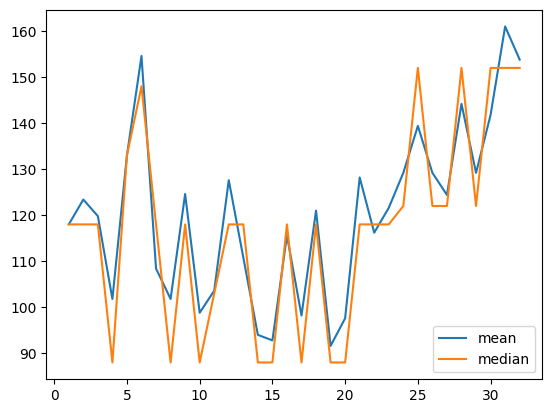

In [14]:
plt.plot(classes, [x['mean'] for x in class_frame_info.values()], label='mean')
plt.plot(classes, [x['median'] for x in class_frame_info.values()], label='median')
plt.legend()
plt.show()

In [ ]:
from fractions import Fraction

def save_holistic(path, holistic, image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = holistic.process(image)
    image.flags.writeable = True

    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

    landmarks = np.concatenate([pose, face, lh, rh])
    np.save(path, landmarks)
    
def sequential_frames(src, holistic, n_frames):
    for f in range(n_frames):
        ret, frame = src.read()
        if ret:
            save_holistic(f'./wlasl-info/landmarks/{v_id}/{f}.npy', holistic, frame)
        else:
            np.save(f'./wlasl-info/landmarks/{v_id}/{f}.npy', np.zeros((1662, )))

def frames_from_video(v_id, n_frames):
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    mp_holistic = mp.solutions.holistic
    
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        src = cv2.VideoCapture(f'./dataset/WLASL/videos/{v_id}.mp4')
        video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)
        os.makedirs(f'./wlasl-info/landmarks/{v_id}', mode=777)
        
        if video_length <= n_frames:
            frame_step = 0
            sequential_frames(src, holistic, n_frames)
        else:
            f = 0
            ratio = round(video_length/n_frames, 1)
            frac = Fraction(ratio).limit_denominator(10)
            
            if ratio == 1.7 or ratio == 1.9:
                frac = Fraction(ratio).limit_denominator(2)
            
            num, den = frac.numerator, frac.denominator
            while f < n_frames:
                for _ in range(min(den, n_frames-f)):
                    ret, frame = src.read()
                    if ret:
                        save_holistic(f'./wlasl-info/landmarks/{v_id}/{f}.npy', holistic, frame)
                    else:
                        np.save(f'./wlasl-info/landmarks/{v_id}/{f}.npy', np.zeros((1662, )))
                    f += 1
                for _ in range(num-den):
                    ret, frame = src.read()

        src.release()

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, root_path, paths, labels, n_frames, batch_size = 2, training = False):
        self.root_path = root_path
        self.paths = paths
        self.labels = labels
        self.n_frames = n_frames
        self.training = training
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.paths))
        if self.training:
            np.random.shuffle(self.indexes)

    def get_video_frames(self, video_paths, classes):
        result_X = []
        result_y = []
        pairs = list(zip(video_paths, classes))

        for path, name in pairs:
            video_frames = frames_from_video(f'{self.root_path}/{name}/{path}', self.n_frames) 
            result_X.append(video_frames)
            result_y.append(name)
        
        return np.array(result_X), np.array(result_y)
            
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        return self.get_video_frames(self.paths[indexes], self.labels[indexes])
    
    def __len__(self):
        return math.floor(len(self.paths) / self.batch_size)
    
    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

In [ ]:
train_gen = DataGenerator('./dataset/lsa64/all/train/', *get_files_and_class_names('./dataset/lsa64/all/train/'), 122, training=True)
val_gen = DataGenerator('./dataset/lsa64/all/val/', *get_files_and_class_names('./dataset/lsa64/all/val/'), 122)

In [ ]:
steps_per_epoch = len(train_gen)
validation_steps = len(val_gen)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU

model = Sequential()
model.add(GRU(512, return_sequences=True, activation='relu', input_shape=(122, 1662)))
model.add(GRU(512, return_sequences=True, activation='relu'))
model.add(GRU(256, return_sequences=False, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='softmax'))

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_gen, epochs=1, steps_per_epoch=steps_per_epoch, validation_data=val_gen, validation_steps=validation_steps)